$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File C:\Users\zidan\.pytorch-datasets\lfw-bush.zip exists, skipping download.
Extracting C:\Users\zidan\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\zidan\.pytorch-datasets\lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


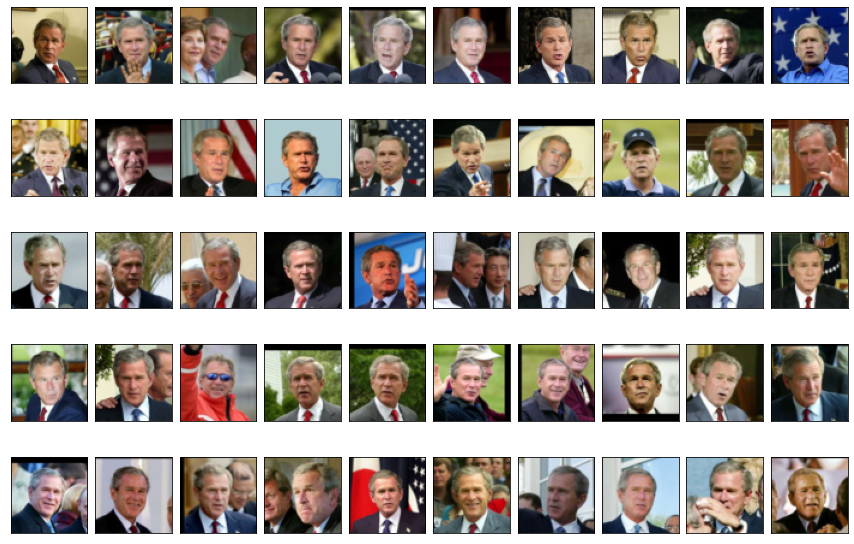

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (fc): Linear(in_features=16384, out_features=1, bias=True)
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.05)
    (9): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), output_padding=(1, 1))
    (10): Identity()
    (11): Identity()
  )
  (fc): Linear(in_features=128, out_features=16384, bias=True)
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

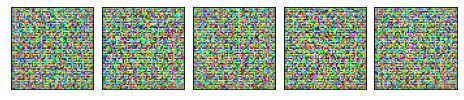

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

### Overfit Sanity Check
Here we check to see that things can converge, find sanity ranges for hypers etc.

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

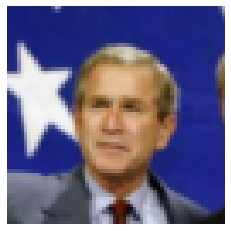

In [50]:
import torch.nn as nn
import torch.optim as optim
from hw3.training import VAETrainer
from torch.utils.data import DataLoader
# ds to memorize
ds_gwb_s = torch.utils.data.Subset(ds_gwb, range(2))
batch_size_ss = 1
dl_gwb_s = DataLoader(ds_gwb_s, batch_size=batch_size_ss, shuffle=False)
dl_iter = iter(dl_gwb_s)
x_overfit = next(dl_iter)
plot.tensor_as_image(x_overfit)

# _ = plot.dataset_first_n(ds_gwb_s, 4, figsize=(15,10))

In [49]:
x_overfit[0].min().item()

-0.9764705896377563

In [51]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']
im_size = ds_gwb_s[0][0].shape

def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
    
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])



def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

print(dsc)
print(gen)
print(hp)

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (fc): Linear(in_features=16384, out_features=1, bias=True)
)
Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(1024, 512, ker

In [28]:
gen_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.99)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)

--- EPOCH 1/100 ---
  0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\zidan\anaconda3\envs\cs236781-hw\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


100%|██████████| 2/2 [00:03<00:00,  1.97s/it]
Discriminator loss: 1.6307907104492188
Generator loss:     1.9354444742202759
Mean score gen:      0.3567536771297455
Mean score gen in dsc:   0.39017489552497864
Mean score real in dsc:   0.6440210938453674


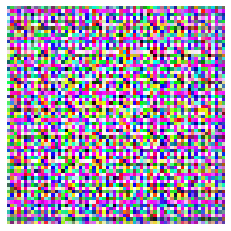

--- EPOCH 2/100 ---
100%|██████████| 2/2 [00:04<00:00,  2.05s/it]
Discriminator loss: 0.5613148957490921
Generator loss:     1.3221974074840546
Mean score gen:      0.5608319044113159
Mean score gen in dsc:   0.0022654621861875057
Mean score real in dsc:   0.9999501705169678


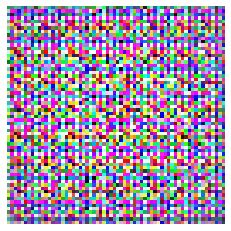

--- EPOCH 3/100 ---
100%|██████████| 2/2 [00:04<00:00,  2.20s/it]
Discriminator loss: 3.5905393958091736
Generator loss:     6.226613602600992
Mean score gen:      0.9970905780792236
Mean score gen in dsc:   0.00027739483630284667
Mean score real in dsc:   0.9982874393463135


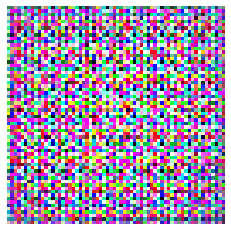

--- EPOCH 4/100 ---
100%|██████████| 2/2 [00:04<00:00,  2.13s/it]
Discriminator loss: 1.9734457731246948
Generator loss:     8.060682818293571
Mean score gen:      0.624672532081604
Mean score gen in dsc:   5.547155443319518e-11
Mean score real in dsc:   0.09192510694265366


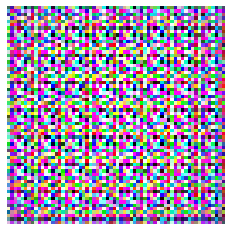

--- EPOCH 5/100 ---
100%|██████████| 2/2 [00:04<00:00,  2.11s/it]
Discriminator loss: -1.9261893033981323
Generator loss:     9.241238653659817
Mean score gen:      9.400742406739937e-09
Mean score gen in dsc:   0.0005785871762782335
Mean score real in dsc:   1.0


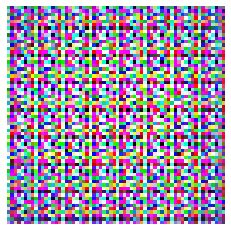

--- EPOCH 6/100 ---
100%|██████████| 2/2 [00:04<00:00,  2.18s/it]
Discriminator loss: -0.3884359896183014
Generator loss:     4.913111448113341
Mean score gen:      0.9993093013763428
Mean score gen in dsc:   0.9754975438117981
Mean score real in dsc:   1.0


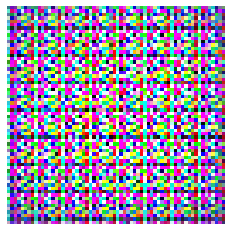

--- EPOCH 7/100 ---
100%|██████████| 2/2 [00:04<00:00,  2.14s/it]
Discriminator loss: -2.195943295955658
Generator loss:     33.83174276351929
Mean score gen:      3.8588953108613183e-28
Mean score gen in dsc:   1.4118368204130843e-13
Mean score real in dsc:   1.0


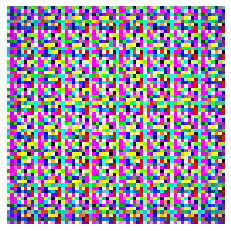

--- EPOCH 8/100 ---
100%|██████████| 2/2 [00:04<00:00,  2.05s/it]
Discriminator loss: 1.4628251194953918
Generator loss:     7.465077601373196
Mean score gen:      0.9751396775245667
Mean score gen in dsc:   0.003777393139898777
Mean score real in dsc:   1.0


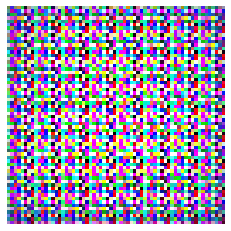

--- EPOCH 9/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.85s/it]
Discriminator loss: 2.7700629234313965
Generator loss:     27.64249324798584
Mean score gen:      7.679109503144953e-19
Mean score gen in dsc:   1.205604007736838e-06
Mean score real in dsc:   1.0


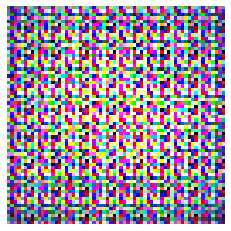

--- EPOCH 10/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.71s/it]
Discriminator loss: 0.09350596368312836
Generator loss:     25.96876049041748
Mean score gen:      5.3187441153568216e-06
Mean score gen in dsc:   1.3799136278080937e-09
Mean score real in dsc:   1.0


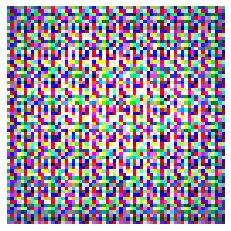

--- EPOCH 11/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.80s/it]
Discriminator loss: 3.8412084579467773
Generator loss:     4.750177043955773
Mean score gen:      7.544565596617758e-05
Mean score gen in dsc:   0.0001655823871260509
Mean score real in dsc:   1.0


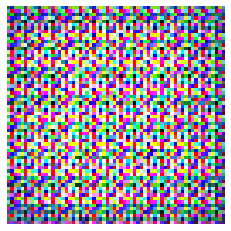

--- EPOCH 12/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.73s/it]
Discriminator loss: 8.294357001781464
Generator loss:     19.173572540283203
Mean score gen:      1.0332959488046356e-10
Mean score gen in dsc:   0.999957263469696
Mean score real in dsc:   1.0


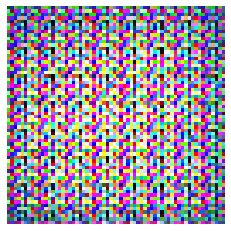

--- EPOCH 13/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.75s/it]
Discriminator loss: -0.1819911003112793
Generator loss:     17.81799602508545
Mean score gen:      1.80072305511203e-07
Mean score gen in dsc:   0.08402872085571289
Mean score real in dsc:   0.999853789806366


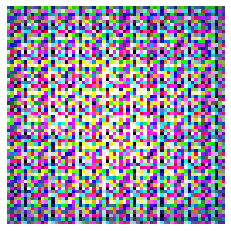

--- EPOCH 14/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.69s/it]
Discriminator loss: 1.1361156702041626
Generator loss:     32.83926725387573
Mean score gen:      3.181454985679011e-06
Mean score gen in dsc:   0.0003397598338779062
Mean score real in dsc:   0.3358937203884125


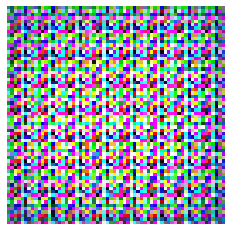

--- EPOCH 15/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.55s/it]
Discriminator loss: -1.2084831893444061
Generator loss:     11.662193115334958
Mean score gen:      0.9918152689933777
Mean score gen in dsc:   0.021821392700076103
Mean score real in dsc:   1.0


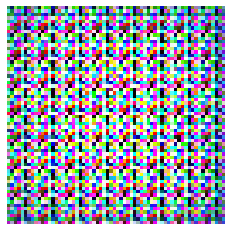

--- EPOCH 16/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.60s/it]
Discriminator loss: 0.176777184009552
Generator loss:     0.4144313335418701
Mean score gen:      0.4365455210208893
Mean score gen in dsc:   0.3345390558242798
Mean score real in dsc:   1.0


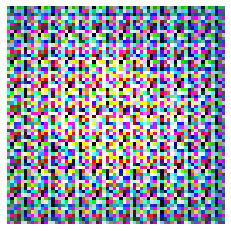

--- EPOCH 17/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.58s/it]
Discriminator loss: 3.543719857931137
Generator loss:     12.179052352905273
Mean score gen:      2.63881867745841e-11
Mean score gen in dsc:   0.9999943375587463
Mean score real in dsc:   1.0


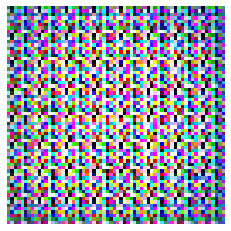

--- EPOCH 18/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.64s/it]
Discriminator loss: -1.486013650894165
Generator loss:     34.077391624450684
Mean score gen:      8.705693501157019e-14
Mean score gen in dsc:   3.34024349513129e-07
Mean score real in dsc:   1.0


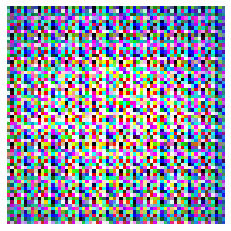

--- EPOCH 19/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
Discriminator loss: 0.655667781829834
Generator loss:     1.8723811507225
Mean score gen:      0.9999998807907104
Mean score gen in dsc:   0.024412835016846657
Mean score real in dsc:   1.0


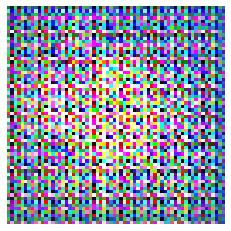

--- EPOCH 20/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.67s/it]
Discriminator loss: 1.1676227152347565
Generator loss:     3.689678013296543
Mean score gen:      0.0006240091752260923
Mean score gen in dsc:   0.00011107127647846937
Mean score real in dsc:   0.9999997615814209


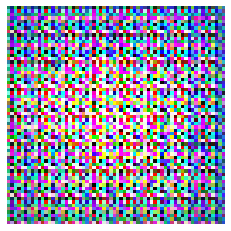

--- EPOCH 21/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.62s/it]
Discriminator loss: -3.219860315322876
Generator loss:     9.89232063293457
Mean score gen:      1.0
Mean score gen in dsc:   0.00453593535348773
Mean score real in dsc:   1.0


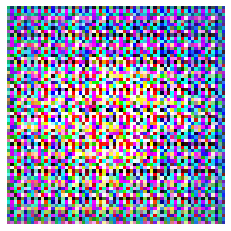

--- EPOCH 22/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
Discriminator loss: -0.8731312900781631
Generator loss:     0.0
Mean score gen:      1.0
Mean score gen in dsc:   0.051636528223752975
Mean score real in dsc:   0.9999999403953552


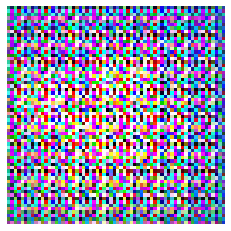

--- EPOCH 23/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.62s/it]
Discriminator loss: 2.421869684010744
Generator loss:     4.960086286067792
Mean score gen:      4.917272963211872e-05
Mean score gen in dsc:   1.1330457709846087e-06
Mean score real in dsc:   0.9999997019767761


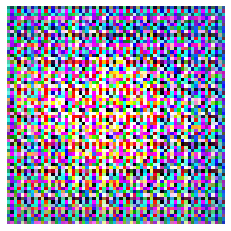

--- EPOCH 24/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.60s/it]
Discriminator loss: 1.666212022304535
Generator loss:     15.864248752593994
Mean score gen:      4.120147334418789e-09
Mean score gen in dsc:   0.6595087051391602
Mean score real in dsc:   1.0


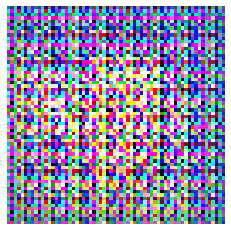

--- EPOCH 25/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.61s/it]
Discriminator loss: 1.7455012649297714
Generator loss:     27.229933619498524
Mean score gen:      0.9999983310699463
Mean score gen in dsc:   1.8305625071324272e-10
Mean score real in dsc:   0.6681923270225525


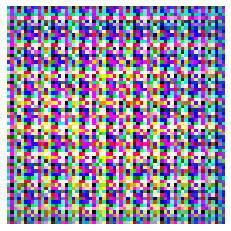

--- EPOCH 26/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.67s/it]
Discriminator loss: 2.4450579807162285
Generator loss:     15.30559778213501
Mean score gen:      0.002843457041308284
Mean score gen in dsc:   0.33349689841270447
Mean score real in dsc:   1.0


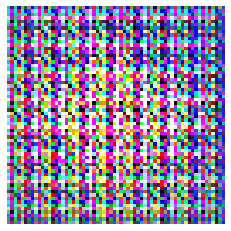

--- EPOCH 27/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.62s/it]
Discriminator loss: 0.7121031284332275
Generator loss:     15.776471316813172
Mean score gen:      0.9999977350234985
Mean score gen in dsc:   1.8291326341568492e-05
Mean score real in dsc:   0.9999945759773254


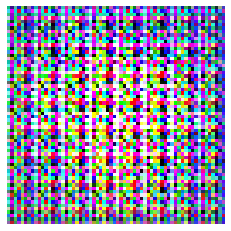

--- EPOCH 28/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.63s/it]
Discriminator loss: -0.7783825993537903
Generator loss:     20.344350576400757
Mean score gen:      2.90036571567122e-18
Mean score gen in dsc:   0.0002982679579872638
Mean score real in dsc:   0.9984686970710754


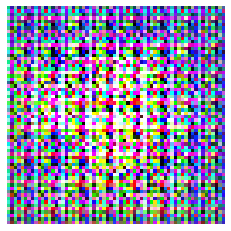

--- EPOCH 29/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.58s/it]
Discriminator loss: 0.7746108174324036
Generator loss:     5.3318253158777225
Mean score gen:      2.337990008527413e-05
Mean score gen in dsc:   0.06533109396696091
Mean score real in dsc:   0.9999794363975525


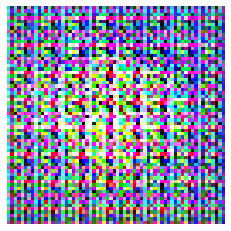

--- EPOCH 30/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.70s/it]
Discriminator loss: -0.12511038780212402
Generator loss:     22.047245025634766
Mean score gen:      1.0
Mean score gen in dsc:   2.8194239348522387e-05
Mean score real in dsc:   0.9999999403953552


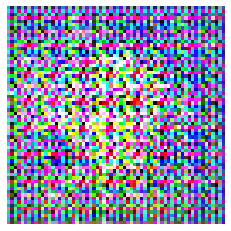

--- EPOCH 31/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.62s/it]
Discriminator loss: 2.8604502975940704
Generator loss:     33.80242347717285
Mean score gen:      2.991613167094802e-17
Mean score gen in dsc:   2.4185963995448923e-11
Mean score real in dsc:   0.6678665280342102


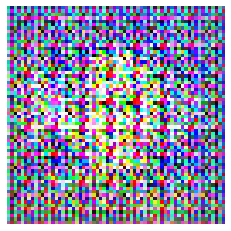

--- EPOCH 32/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.77s/it]
Discriminator loss: 1.4891211092472076
Generator loss:     29.56295871734619
Mean score gen:      3.2565832952968776e-05
Mean score gen in dsc:   0.004080204293131828
Mean score real in dsc:   1.0


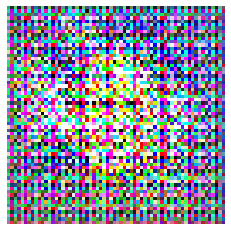

--- EPOCH 33/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.62s/it]
Discriminator loss: 4.276893712580204
Generator loss:     34.30304824223276
Mean score gen:      1.602659405877204e-30
Mean score gen in dsc:   0.9993303418159485
Mean score real in dsc:   1.0


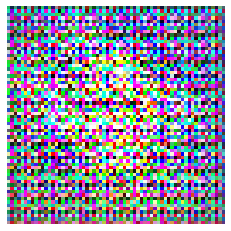

--- EPOCH 34/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
Discriminator loss: 2.5779625177383423
Generator loss:     78.23327255249023
Mean score gen:      9.381260418767737e-34
Mean score gen in dsc:   4.5051609022602836e-26
Mean score real in dsc:   0.6604036688804626


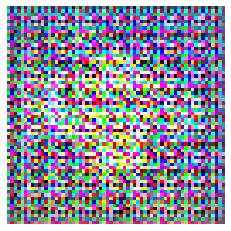

--- EPOCH 35/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.63s/it]
Discriminator loss: -2.141118884086609
Generator loss:     46.899837493896484
Mean score gen:      8.969546868853046e-17
Mean score gen in dsc:   1.333857192754829e-17
Mean score real in dsc:   0.995101273059845


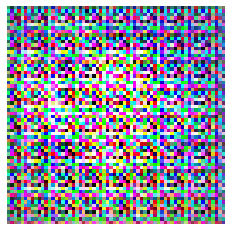

--- EPOCH 36/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
Discriminator loss: 1.5480784475803375
Generator loss:     36.82148742675781
Mean score gen:      2.4148698383047e-22
Mean score gen in dsc:   2.3129424110499522e-17
Mean score real in dsc:   0.9999950528144836


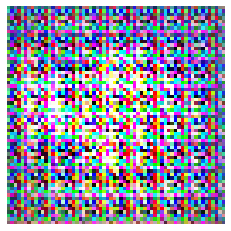

--- EPOCH 37/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.64s/it]
Discriminator loss: 0.21409228444099426
Generator loss:     11.30516529083252
Mean score gen:      5.417765351012349e-05
Mean score gen in dsc:   0.3288475275039673
Mean score real in dsc:   0.9999961256980896


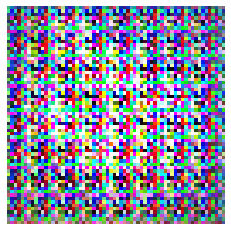

--- EPOCH 38/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.75s/it]
Discriminator loss: 0.770250141620636
Generator loss:     0.0007445630035363138
Mean score gen:      1.0
Mean score gen in dsc:   0.000875961733981967
Mean score real in dsc:   0.6664416790008545


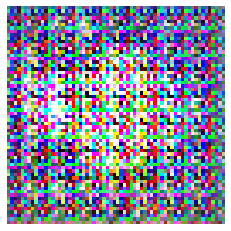

--- EPOCH 39/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.72s/it]
Discriminator loss: 5.170430481433868
Generator loss:     21.411889850965963
Mean score gen:      2.522775240231203e-19
Mean score gen in dsc:   0.9993909001350403
Mean score real in dsc:   1.0


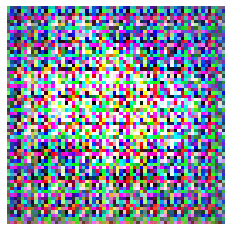

--- EPOCH 40/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
Discriminator loss: 1.0827469229698181
Generator loss:     43.90401840209961
Mean score gen:      3.643486414579261e-17
Mean score gen in dsc:   9.559729896579938e-09
Mean score real in dsc:   0.9909980893135071


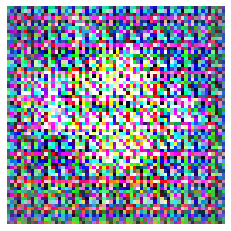

--- EPOCH 41/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.64s/it]
Discriminator loss: 0.8789702653884888
Generator loss:     29.56190299987793
Mean score gen:      4.376351152535164e-15
Mean score gen in dsc:   8.087771446486924e-13
Mean score real in dsc:   0.6054096817970276


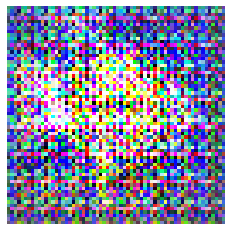

--- EPOCH 42/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
Discriminator loss: 1.62260103225708
Generator loss:     1.7881390590446244e-07
Mean score gen:      0.9999996423721313
Mean score gen in dsc:   0.3340502977371216
Mean score real in dsc:   1.0


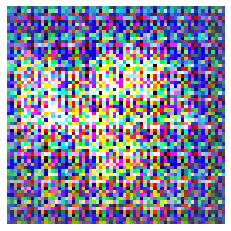

--- EPOCH 43/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.68s/it]
Discriminator loss: 0.22014236450195312
Generator loss:     0.6351718902587891
Mean score gen:      1.0
Mean score gen in dsc:   0.001081185764633119
Mean score real in dsc:   1.0


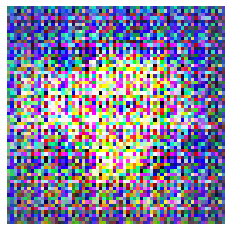

--- EPOCH 44/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
Discriminator loss: 2.892479419708252
Generator loss:     6.092162132263184
Mean score gen:      1.0
Mean score gen in dsc:   2.008432238653768e-05
Mean score real in dsc:   1.0


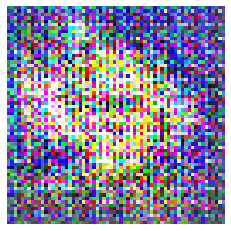

--- EPOCH 45/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.74s/it]
Discriminator loss: 5.039968132972717
Generator loss:     19.105632781982422
Mean score gen:      2.5413134124137973e-17
Mean score gen in dsc:   0.9849376678466797
Mean score real in dsc:   0.9999999403953552


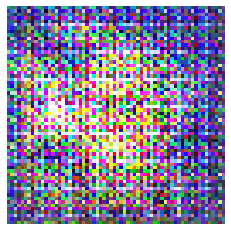

--- EPOCH 46/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.62s/it]
Discriminator loss: 9.67044973373413
Generator loss:     14.15562629699707
Mean score gen:      1.0
Mean score gen in dsc:   0.002166593912988901
Mean score real in dsc:   8.75824582635687e-07


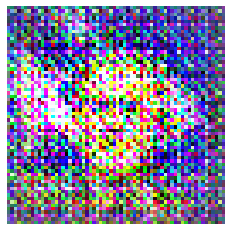

--- EPOCH 47/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.69s/it]
Discriminator loss: 2.971112847328186
Generator loss:     0.9523609266616404
Mean score gen:      0.9999252557754517
Mean score gen in dsc:   1.0727279004640877e-05
Mean score real in dsc:   1.0


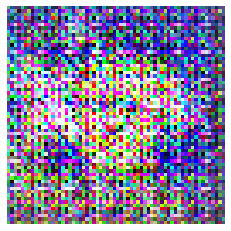

--- EPOCH 48/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.60s/it]
Discriminator loss: 3.428661346435547
Generator loss:     0.00354082346893847
Mean score gen:      0.9929433465003967
Mean score gen in dsc:   4.601214076416227e-09
Mean score real in dsc:   1.0


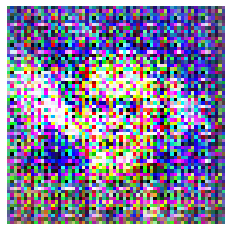

--- EPOCH 49/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.68s/it]
Discriminator loss: 5.122536063194275
Generator loss:     18.04607367515564
Mean score gen:      5.91740415348263e-13
Mean score gen in dsc:   0.00010352733806939796
Mean score real in dsc:   0.9999940991401672


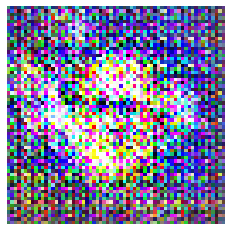

--- EPOCH 50/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.64s/it]
Discriminator loss: 8.419125616550446
Generator loss:     11.426466941833496
Mean score gen:      1.1887674178368002e-10
Mean score gen in dsc:   0.0002859327069018036
Mean score real in dsc:   0.9448910355567932


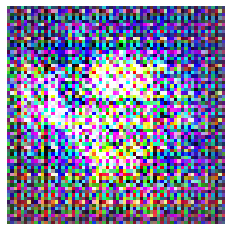

--- EPOCH 51/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
Discriminator loss: 0.7883872389793396
Generator loss:     0.00017860322259366512
Mean score gen:      0.9996428489685059
Mean score gen in dsc:   1.3106334684209742e-08
Mean score real in dsc:   0.9999867081642151


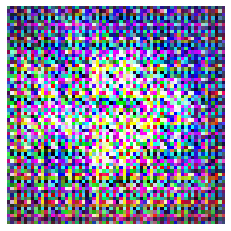

--- EPOCH 52/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
Discriminator loss: 12.408475875854492
Generator loss:     22.00682544708252
Mean score gen:      4.131917706573858e-18
Mean score gen in dsc:   4.0019249498221695e-16
Mean score real in dsc:   0.6663560271263123


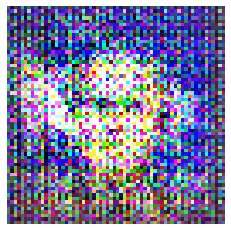

--- EPOCH 53/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.74s/it]
Discriminator loss: 0.32423946261405945
Generator loss:     11.034041464328766
Mean score gen:      0.19554553925991058
Mean score gen in dsc:   0.00042991197551600635
Mean score real in dsc:   0.8679642677307129


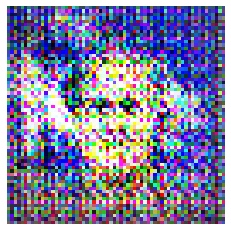

--- EPOCH 54/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
Discriminator loss: 3.4164438247680664
Generator loss:     0.5127252313795907
Mean score gen:      0.9998970031738281
Mean score gen in dsc:   0.3318791687488556
Mean score real in dsc:   0.6848769187927246


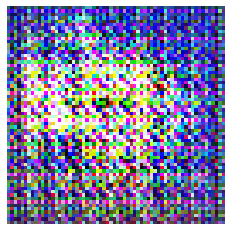

--- EPOCH 55/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.67s/it]
Discriminator loss: 0.17694315314292908
Generator loss:     15.083186447620307
Mean score gen:      0.9999994039535522
Mean score gen in dsc:   0.0009511820389889181
Mean score real in dsc:   0.9972565770149231


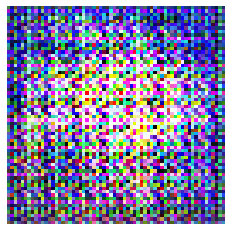

--- EPOCH 56/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.71s/it]
Discriminator loss: 0.752098798751831
Generator loss:     6.905877530574003
Mean score gen:      1.0037642823590431e-06
Mean score gen in dsc:   0.03886697441339493
Mean score real in dsc:   0.6722933650016785


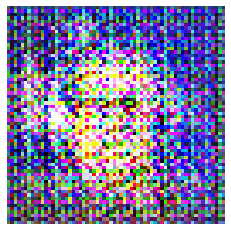

--- EPOCH 57/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.60s/it]
Discriminator loss: 4.391094475984573
Generator loss:     14.343476295471191
Mean score gen:      3.478682728159932e-13
Mean score gen in dsc:   0.9966729283332825
Mean score real in dsc:   0.9999959468841553


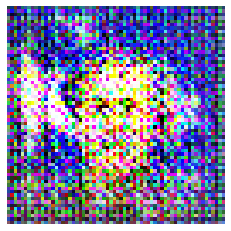

--- EPOCH 58/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.63s/it]
Discriminator loss: 3.8977864384651184
Generator loss:     30.901042938232422
Mean score gen:      3.4727960507296984e-09
Mean score gen in dsc:   3.7661729165908403e-16
Mean score real in dsc:   0.25127583742141724


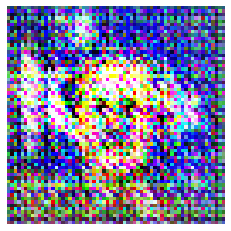

--- EPOCH 59/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.71s/it]
Discriminator loss: 2.7037992626428604
Generator loss:     6.438119888305664
Mean score gen:      2.5581159661669517e-06
Mean score gen in dsc:   0.3251752555370331
Mean score real in dsc:   1.0


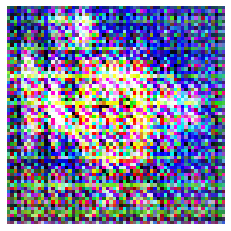

--- EPOCH 60/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
Discriminator loss: 1.927272915840149
Generator loss:     0.0
Mean score gen:      1.0
Mean score gen in dsc:   9.047752769220097e-09
Mean score real in dsc:   0.9999998211860657


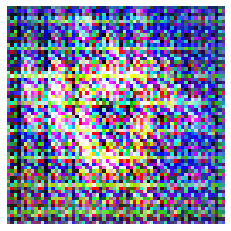

--- EPOCH 61/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.67s/it]
Discriminator loss: 0.6045776605606079
Generator loss:     9.862005990929902
Mean score gen:      2.7741569041950243e-09
Mean score gen in dsc:   7.861953275900557e-13
Mean score real in dsc:   0.99715256690979


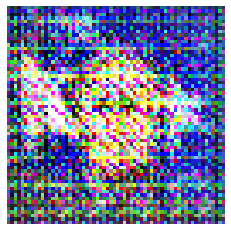

--- EPOCH 62/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
Discriminator loss: 2.3132378458976746
Generator loss:     8.779316902160645
Mean score gen:      1.0
Mean score gen in dsc:   0.011292302049696445
Mean score real in dsc:   0.8683457374572754


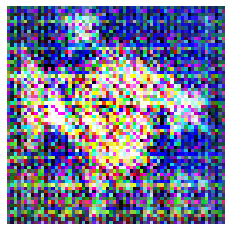

--- EPOCH 63/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.56s/it]
Discriminator loss: 2.4182450771331787
Generator loss:     19.10081434249878
Mean score gen:      6.217813807232742e-13
Mean score gen in dsc:   0.9190554022789001
Mean score real in dsc:   0.99969482421875


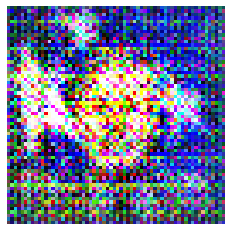

--- EPOCH 64/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.70s/it]
Discriminator loss: 2.4385390877723694
Generator loss:     4.4042136780917645
Mean score gen:      0.9309151768684387
Mean score gen in dsc:   0.056294143199920654
Mean score real in dsc:   0.15176619589328766


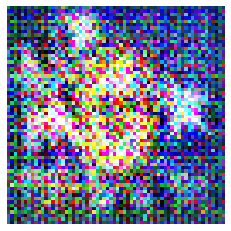

--- EPOCH 65/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.72s/it]
Discriminator loss: 3.2403136491775513
Generator loss:     6.519356846809387
Mean score gen:      9.569544999976642e-06
Mean score gen in dsc:   0.365602970123291
Mean score real in dsc:   1.0


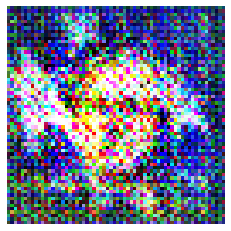

--- EPOCH 66/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
Discriminator loss: 2.5908968448638916
Generator loss:     18.51374864578247
Mean score gen:      7.561701265146326e-11
Mean score gen in dsc:   1.3318958436148165e-10
Mean score real in dsc:   0.9468722343444824


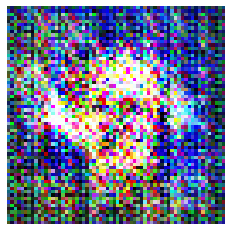

--- EPOCH 67/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
Discriminator loss: 3.252504587173462
Generator loss:     0.0075808553876868245
Mean score gen:      0.9849581718444824
Mean score gen in dsc:   3.40714212399007e-09
Mean score real in dsc:   0.7806534767150879


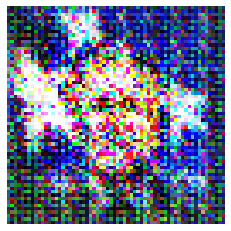

--- EPOCH 68/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
Discriminator loss: 4.696475625038147
Generator loss:     12.726169073779602
Mean score gen:      8.841615807553271e-12
Mean score gen in dsc:   0.9999508857727051
Mean score real in dsc:   0.9999999403953552


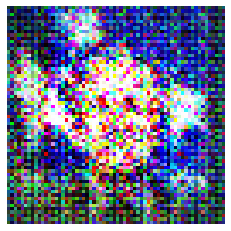

--- EPOCH 69/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
Discriminator loss: -1.1655063927173615
Generator loss:     24.012928009033203
Mean score gen:      5.57407245360686e-12
Mean score gen in dsc:   5.728148511074949e-10
Mean score real in dsc:   0.8005595803260803


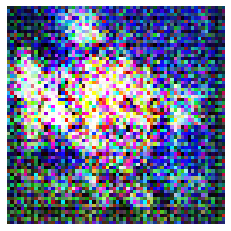

--- EPOCH 70/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.75s/it]
Discriminator loss: 1.811346173286438
Generator loss:     14.695146083831787
Mean score gen:      1.965130832104478e-05
Mean score gen in dsc:   1.3376958122535143e-05
Mean score real in dsc:   0.996690571308136


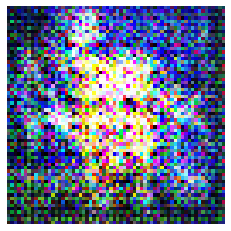

--- EPOCH 71/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.67s/it]
Discriminator loss: 0.05469800531864166
Generator loss:     3.9994078278541565
Mean score gen:      0.000614200544077903
Mean score gen in dsc:   0.0012762699043378234
Mean score real in dsc:   0.9882300496101379


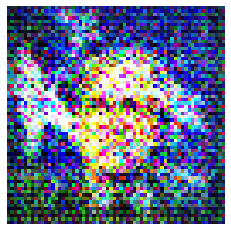

--- EPOCH 72/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
Discriminator loss: 1.0265784859657288
Generator loss:     13.871340036392212
Mean score gen:      7.945485380744799e-10
Mean score gen in dsc:   1.2371223192531033e-06
Mean score real in dsc:   0.7084500193595886


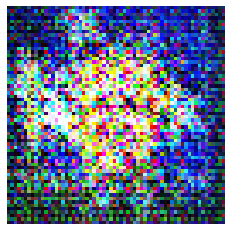

--- EPOCH 73/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.63s/it]
Discriminator loss: 1.6138677299022675
Generator loss:     1.0525811314581972
Mean score gen:      0.12182597070932388
Mean score gen in dsc:   0.6174737215042114
Mean score real in dsc:   0.9999687075614929


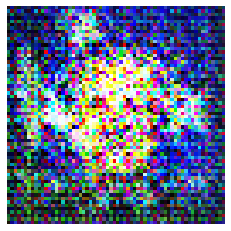

--- EPOCH 74/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.63s/it]
Discriminator loss: 3.1440529823303223
Generator loss:     7.594332365319133
Mean score gen:      0.979357898235321
Mean score gen in dsc:   0.00800106581300497
Mean score real in dsc:   0.009753502905368805


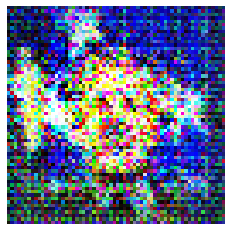

--- EPOCH 75/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.82s/it]
Discriminator loss: 1.9361849427223206
Generator loss:     4.891908407211304
Mean score gen:      0.00016740307910367846
Mean score gen in dsc:   0.2372174859046936
Mean score real in dsc:   1.0


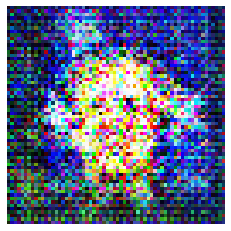

--- EPOCH 76/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.83s/it]
Discriminator loss: -0.3721408247947693
Generator loss:     0.8906169533379398
Mean score gen:      0.9999881982803345
Mean score gen in dsc:   0.08120078593492508
Mean score real in dsc:   0.9999485015869141


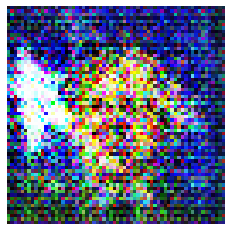

--- EPOCH 77/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.85s/it]
Discriminator loss: 0.706741601228714
Generator loss:     1.7526285307249054
Mean score gen:      0.03007369115948677
Mean score gen in dsc:   0.4281634986400604
Mean score real in dsc:   1.0


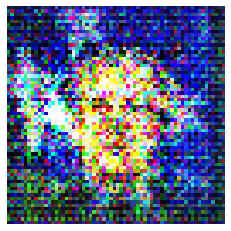

--- EPOCH 78/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.91s/it]
Discriminator loss: -0.29638659954071045
Generator loss:     3.041650652885437
Mean score gen:      0.09039351344108582
Mean score gen in dsc:   0.17631442844867706
Mean score real in dsc:   0.8403865694999695


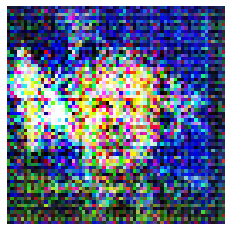

--- EPOCH 79/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.79s/it]
Discriminator loss: 1.6673332452774048
Generator loss:     5.278287410736084
Mean score gen:      0.28685203194618225
Mean score gen in dsc:   5.27001429873053e-05
Mean score real in dsc:   0.692951500415802


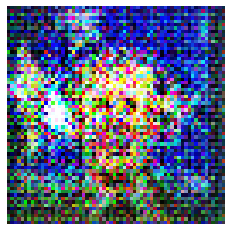

--- EPOCH 80/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.95s/it]
Discriminator loss: 4.083584100008011
Generator loss:     7.80253529548645
Mean score gen:      1.8734801415121183e-05
Mean score gen in dsc:   0.9569843411445618
Mean score real in dsc:   0.9999993443489075


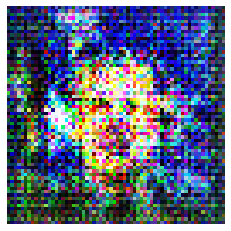

--- EPOCH 81/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.81s/it]
Discriminator loss: 4.116117477416992
Generator loss:     12.249175056815147
Mean score gen:      0.6665439605712891
Mean score gen in dsc:   0.003382444381713867
Mean score real in dsc:   0.018768349662423134


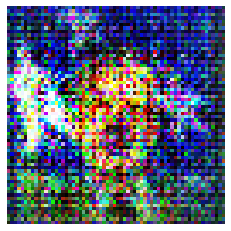

--- EPOCH 82/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.75s/it]
Discriminator loss: 2.640051245689392
Generator loss:     0.002566890419984702
Mean score gen:      0.9949027299880981
Mean score gen in dsc:   0.3332173526287079
Mean score real in dsc:   0.9999999403953552


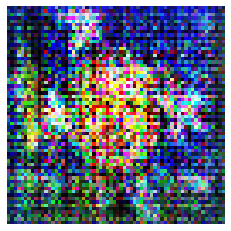

--- EPOCH 83/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.80s/it]
Discriminator loss: -0.6067286729812622
Generator loss:     0.6526369526982307
Mean score gen:      0.8738633990287781
Mean score gen in dsc:   0.0008277406450361013
Mean score real in dsc:   0.998469352722168


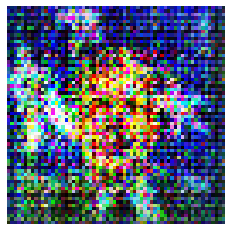

--- EPOCH 84/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.89s/it]
Discriminator loss: 2.76872156560421
Generator loss:     12.183172384276986
Mean score gen:      2.6936427047208333e-11
Mean score gen in dsc:   0.004831712692975998
Mean score real in dsc:   0.999995768070221


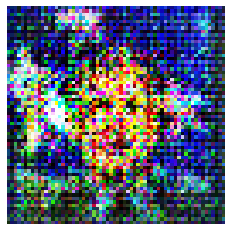

--- EPOCH 85/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.82s/it]
Discriminator loss: 2.0799386501312256
Generator loss:     8.32138759829104
Mean score gen:      6.024400533988228e-08
Mean score gen in dsc:   0.054670557379722595
Mean score real in dsc:   1.0


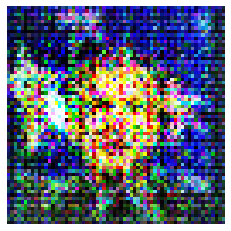

--- EPOCH 86/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.67s/it]
Discriminator loss: 1.640805572271347
Generator loss:     10.296699047088623
Mean score gen:      2.0102294229218387e-07
Mean score gen in dsc:   0.8335550427436829
Mean score real in dsc:   0.9999966025352478


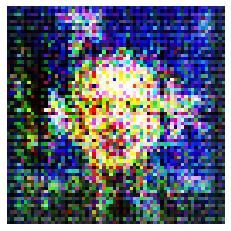

--- EPOCH 87/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
Discriminator loss: 3.9955270886421204
Generator loss:     7.31359076499939
Mean score gen:      0.002121045719832182
Mean score gen in dsc:   5.4968816165512635e-09
Mean score real in dsc:   0.00016456884623039514


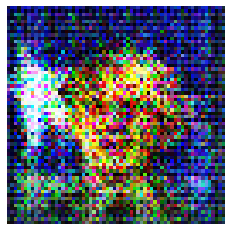

--- EPOCH 88/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.72s/it]
Discriminator loss: 4.551403909921646
Generator loss:     12.969896376132962
Mean score gen:      5.4261426081503306e-12
Mean score gen in dsc:   0.9970360398292542
Mean score real in dsc:   0.9998950958251953


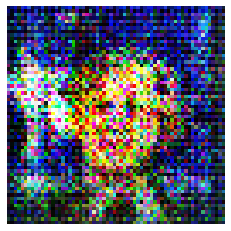

--- EPOCH 89/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.70s/it]
Discriminator loss: 7.721585273742676
Generator loss:     9.85840392112732
Mean score gen:      5.120127752888948e-07
Mean score gen in dsc:   0.31070414185523987
Mean score real in dsc:   0.9999979138374329


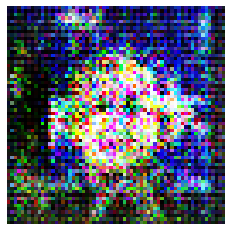

--- EPOCH 90/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.65s/it]
Discriminator loss: 3.1060792207717896
Generator loss:     6.4191460609436035
Mean score gen:      0.007879271171987057
Mean score gen in dsc:   0.0037166818510740995
Mean score real in dsc:   0.6689562797546387


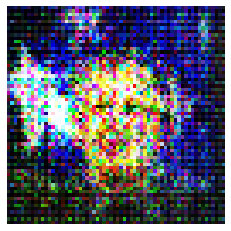

--- EPOCH 91/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.67s/it]
Discriminator loss: 1.311030626296997
Generator loss:     12.093650713562965
Mean score gen:      3.4240551366471195e-11
Mean score gen in dsc:   0.04985251650214195
Mean score real in dsc:   0.765761137008667


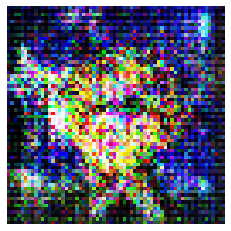

--- EPOCH 92/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.70s/it]
Discriminator loss: 1.8949984014034271
Generator loss:     10.998475790023804
Mean score gen:      0.007951079867780209
Mean score gen in dsc:   0.33551958203315735
Mean score real in dsc:   0.999986469745636


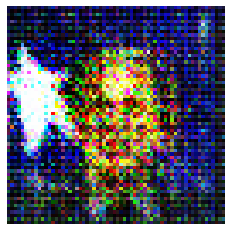

--- EPOCH 93/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.82s/it]
Discriminator loss: 1.1393916457891464
Generator loss:     15.273805618286133
Mean score gen:      4.129559272314509e-08
Mean score gen in dsc:   1.2821999018086672e-10
Mean score real in dsc:   0.6508905291557312


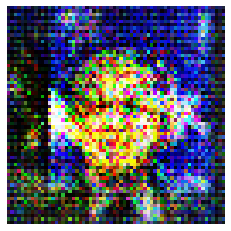

--- EPOCH 94/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.72s/it]
Discriminator loss: 1.3107756078243256
Generator loss:     3.7393141984939575
Mean score gen:      0.0016891267150640488
Mean score gen in dsc:   0.3202393651008606
Mean score real in dsc:   0.9850468635559082


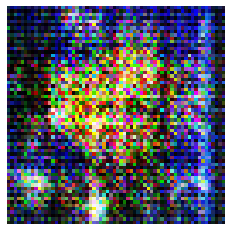

--- EPOCH 95/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.81s/it]
Discriminator loss: 1.124647170305252
Generator loss:     3.9715460367297055
Mean score gen:      0.9997380375862122
Mean score gen in dsc:   0.3682182729244232
Mean score real in dsc:   0.6745805740356445


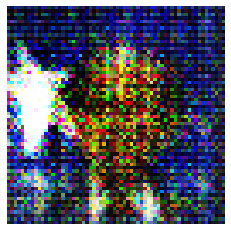

--- EPOCH 96/100 ---
100%|██████████| 2/2 [00:03<00:00,  1.80s/it]
Discriminator loss: -0.03647029399871826
Generator loss:     4.770235575153492
Mean score gen:      7.202938286354765e-05
Mean score gen in dsc:   0.003627314232289791
Mean score real in dsc:   0.7410368323326111


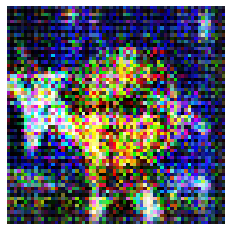

--- EPOCH 97/100 ---
100%|██████████| 2/2 [00:04<00:00,  2.10s/it]
Discriminator loss: 1.8340261578559875
Generator loss:     25.85015296936035
Mean score gen:      6.407377666634018e-12
Mean score gen in dsc:   2.9219253860901517e-07
Mean score real in dsc:   0.9999932646751404


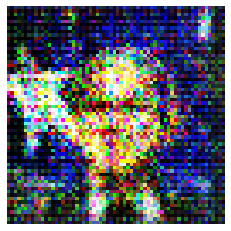

--- EPOCH 98/100 ---
100%|██████████| 2/2 [00:05<00:00,  2.65s/it]
Discriminator loss: 10.564862966537476
Generator loss:     18.28748369216919
Mean score gen:      1.415113143853064e-12
Mean score gen in dsc:   0.9994435906410217
Mean score real in dsc:   1.0


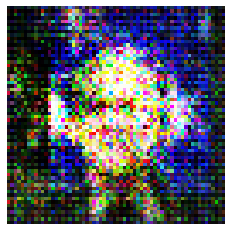

--- EPOCH 99/100 ---
100%|██████████| 2/2 [00:05<00:00,  2.54s/it]
Discriminator loss: 3.93607959151268
Generator loss:     8.50644063949585
Mean score gen:      0.0018742639804258943
Mean score gen in dsc:   2.9827040748386935e-07
Mean score real in dsc:   0.1381806582212448


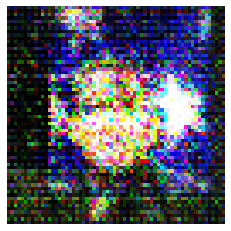

--- EPOCH 100/100 ---
100%|██████████| 2/2 [00:07<00:00,  3.83s/it]
Discriminator loss: 1.195668339729309
Generator loss:     1.8775029475800693
Mean score gen:      0.023600921034812927
Mean score gen in dsc:   0.3486274182796478
Mean score real in dsc:   0.9998078942298889


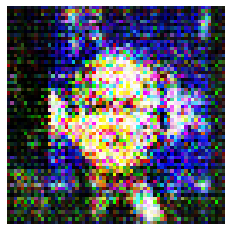

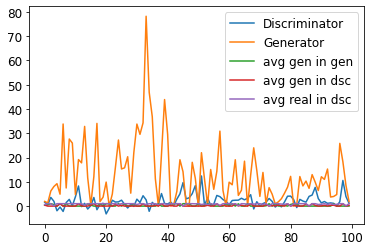

In [52]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100
try:
    dsc_avg_losses, gen_avg_losses, mean_classification_gen, mean_classification_gen_dsc, mean_classification_real_dsc = [], [], [], [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses, classifications_gen, classifications_fake_dsc, classifications_real_dsc = [], [], [], [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_gwb_s.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_gwb_s):
                x_data = x_data.to(device)
                dsc_loss, gen_loss, dst_fake_classification, dst_real_classification, gen_classification = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                classifications_gen.append(gen_classification)
                classifications_real_dsc.append(dst_real_classification)
                classifications_fake_dsc.append(dst_fake_classification)

                pbar.update()
        
        mean_classification_gen.append(np.mean(gen_classification))
        mean_classification_gen_dsc.append(np.mean(dst_fake_classification))
        mean_classification_real_dsc.append(np.mean(dst_real_classification))
        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        

        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        print(f'Mean score gen:      {mean_classification_gen[-1]}')
        print(f'Mean score gen in dsc:   {mean_classification_gen_dsc[-1]}')
        print(f'Mean score real in dsc:   {mean_classification_real_dsc[-1]}')
        fig, _ = plot.tensor_as_image(gen.sample(1, with_grad=False))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

plt.figure()
plt.plot(dsc_avg_losses, label='Discriminator')
plt.plot(gen_avg_losses, label='Generator')
plt.plot(mean_classification_gen, label='avg gen in gen')
plt.plot(mean_classification_gen_dsc, label='avg gen in dsc')
plt.plot(mean_classification_real_dsc, label='avg real in dsc')
plt.legend()
plt.show()



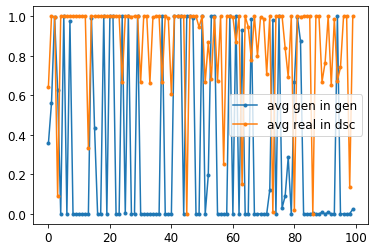

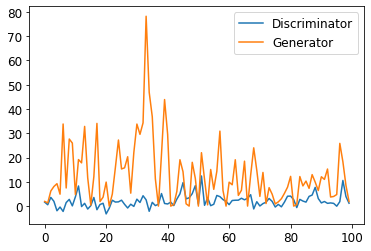

In [54]:
plt.figure()
plt.plot(mean_classification_gen, marker = '.', label='avg gen in gen')
# plt.plot(mean_classification_gen_dsc, marker = '.', label='avg gen in dsc')
plt.plot(mean_classification_real_dsc, marker = '.', label='avg real in dsc')
plt.legend()
plt.show()

plt.figure()
plt.plot(dsc_avg_losses, label='Discriminator')
plt.plot(gen_avg_losses, label='Generator')
plt.legend()
plt.show()

(<Figure size 576x576 with 5 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>], dtype=object))

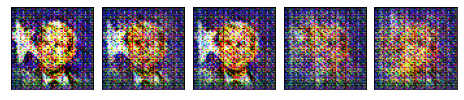

In [26]:
samples = gen.sample(5, with_grad=False)
plot.tensors_as_images(samples.cpu())

### Finish overfit

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [22]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 64, 'z_dim': 100, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.99)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.99)}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

In [29]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device,)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

--- EPOCH 1/100 ---
  0%|          | 0/9 [00:00<?, ?it/s]

: 

In [ ]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [ ]:
from cs236781.answers import display_answer
import hw3.answers as answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [ ]:
display_answer(answers.part3_q1)


### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [ ]:
display_answer(answers.part3_q2)

### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [ ]:
display_answer(answers.part3_q3)
